In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd
from torch.nn import Module
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
import math

# Введем константы из задания
#Для воспроизведения результатов
np.random.seed(11)

#Другие константы
num_neuro_1 = 10
num_neuro_2 = 10
num_neuro_3 = 5

RES_DIR = './results/'
DATA_DIR = './CCPP/'
HOME_DIR = './'

In [2]:
train_data = pd.read_csv(HOME_DIR+'split_data/train_set.csv').values
valid_data = pd.read_csv(HOME_DIR+'split_data/val_set.csv').values
test_data = pd.read_csv(HOME_DIR+'split_data/test_set.csv').values

print('\n', train_data.shape, len(valid_data), len(test_data))

batch_size = len(train_data)
in_size = train_data.shape[1]-1


 (5158, 5) 3868 1290


In [3]:
class CCPPDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    

In [4]:
dataset = CCPPDataset(train_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
#Свой класс Linear
class Linear_batch(Module):
    def __init__(self, in_size, out_size, sigma):
        super(Linear_batch, self).__init__()
        self.W = Parameter(sigma * torch.randn((out_size, in_size)))
        self.b = Parameter(sigma * torch.randn(out_size))
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return torch.matmul(self.x, self.W.t()) + self.b
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = torch.matmul(self.x.t(), dz)
        self.db = torch.sum(dz, 0)
        # вычисляем производную по входу
        dz = torch.matmul(dz, self.W) 
        # возвращаем dx для продолжения алгоритма
        return dz

In [6]:
class tanh(Module):
    def forward(self, x):
        self.fx = (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
    
    def backward(self, dz):
        return (1 - self.fx**2)*dz

In [7]:
class Quadratic_loss(Module):
    def __init__(self):
        super(Quadratic_loss, self).__init__()
        self.er = 0
        
    def forward(self, y_pred, y_true):
        self.er = y_pred - y_true
        self.n = len(y_true)
        return self.er**2 / self.n
    
    def backward(self, dz):
        return 2/self.n * self.er

In [12]:
class MainNet(nn.Module):
    def __init__(self, num):
        super(MainNet, self).__init__()
        self.lin1 = Linear_batch(num, num_neuro_1, 2/102)
        self.tanh1 = tanh()
        self.lin2 = Linear_batch(num_neuro_1, num_neuro_2, 2/102)
        self.tanh2 = tanh()
        self.lin3 = Linear_batch(num_neuro_2, num_neuro_3, 2/102)
        self.tanh3 = tanh()
        self.lin4 = Linear_batch(num_neuro_3, 1, 2/102)
        self.tanh4 = tanh()
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.tanh1(x)
        x = self.lin2(x)
        x = self.tanh2(x)
        x = self.lin3(x)
        x = self.tanh3(x)
        x = self.lin4(x)
        x = self.tanh4(x)
        return x
    
    def backward(self, z):
        z = self.tanh4.backward(z)
        z = self.lin4.backward(z)
        z = self.tanh3.backward(z)
        z = self.lin3.backward(z)
        z = self.tanh2.backward(z)
        z = self.lin2.backward(z)
        z = self.tanh1.backward(z)
        z = self.lin1.backward(z)
        return z

In [13]:
class LayerNet(nn.Module):
    def __init__(self):
        super(LayerNet, self).__init__()
        self.lin1 = Linear_batch(1, 10, 2/102)
        self.tanh1 = tanh()
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.tanh1(x)
        return x
    
    def backward(self, z):
        z = self.tanh1.backward(z)
        z = self.lin1.backward(z)
        return z

In [14]:
def load_wts(net, load_dir, before=False, is_pytorch=False):  
    path = load_dir
    if before:
        if is_pytorch:
            net.load_state_dict(torch.load(load_dir+'params_before.csv'))
        else:
            net.lin1.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w1_before.csv', sep=',').values))
            net.lin2.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w2_before.csv', sep=',').values))
            net.lin1.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b1_before.csv', sep=',').values).squeeze())
            net.lin2.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b2_before.csv', sep=',').values).squeeze())
            net.lin3.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w3_before.csv', sep=',').values))
            net.lin4.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w4_before.csv', sep=',').values))
            net.lin3.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b3_before.csv', sep=',').values).squeeze())
            net.lin4.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b4_before.csv', sep=',').values).squeeze())
    else:
        if is_pytorch:
            net.load_state_dict(torch.load(load_dir+'params.csv'))
        else:
            net.lin1.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w1_.csv', sep=',').values))
            net.lin2.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w2_.csv', sep=',').values))
            net.lin1.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b1_.csv', sep=',').values).squeeze())
            net.lin2.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b2_.csv', sep=',').values).squeeze())
            net.lin3.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w3_.csv', sep=',').values))
            net.lin4.W = Parameter(torch.FloatTensor(pd.read_csv(path+'w4_.csv', sep=',').values))
            net.lin3.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b3_.csv', sep=',').values).squeeze())
            net.lin4.b = Parameter(torch.FloatTensor(pd.read_csv(path+'b4_.csv', sep=',').values).squeeze())
    return net

In [15]:
net = MainNet(num=in_size)
print(net)

net = load_wts(net, HOME_DIR+'split_data/', before=True, is_pytorch=False)

MainNet(
  (lin1): Linear_batch(
  )
  (tanh1): tanh(
  )
  (lin2): Linear_batch(
  )
  (tanh2): tanh(
  )
  (lin3): Linear_batch(
  )
  (tanh3): tanh(
  )
  (lin4): Linear_batch(
  )
  (tanh4): tanh(
  )
)


In [16]:
net.state_dict()

OrderedDict([('lin1.W', 
              1.00000e-02 *
                0.6342 -1.5806 -0.9526 -3.3209
                2.0745 -0.5966  1.2304  0.0677
                1.0485  1.0904  0.7758 -0.4275
               -2.5902  1.7904 -1.8824  2.0768
                4.0467  1.7170  2.9493  1.2990
               -2.4260 -0.7553 -4.1591  0.0238
               -1.3733 -3.1897 -0.7195  2.6180
               -1.5315  0.9091 -1.0397 -0.3579
                1.6079 -0.1178  0.4550 -1.8520
               -1.2474  2.5717  1.5685 -0.6351
              [torch.FloatTensor of size 10x4]), ('lin1.b', 
              1.00000e-02 *
               -0.9126
               -1.5187
                0.4733
               -2.2388
                1.7904
                0.3068
                2.4439
               -2.1016
               -2.7033
                3.7243
              [torch.FloatTensor of size 10]), ('lin2.W', 
              1.00000e-02 *
                1.0834 -1.2397 -3.8349  1.8899 -1.3222  2.7101  0.6538 

In [21]:
from IPython import display
lr = 1e1
#decay = 1
num_epoch = 100000
#weight2_hidden = []
#wieght2_out = []
err_epoh = []
valid_err_epoh = []
test_err_epoh = []

In [23]:
for epoch in range(num_epoch):
    
    err_acc = 0
    valid_err_acc = 0
    test_err_acc = 0

    #lr = (lr0 + epoch)**(-1/3)
    
    if (epoch%1000 == 1):
        plt.grid(True)
        plt.plot(err_epoh, color='r')
        plt.plot(valid_err_epoh, color='b')
        plt.plot(test_err_epoh, color='g')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        print(epoch)
        print("train: ", err_epoh[epoch-1])
        print("valid: ", valid_err_epoh[epoch-1])
        print("test: ", test_err_epoh[epoch-1])

    
    for i_batch, data in enumerate(dataloader):
        #просчет производных
        loss = Quadratic_loss()
        
        inputs, labels = data[:,0:in_size], data[:,in_size]
        inputs = autograd.Variable((inputs).float()).unsqueeze(1)
        print(inputs)
        labels = autograd.Variable((labels).float()).unsqueeze(1)
        print(labels)
        
        valid_inputs = autograd.Variable(torch.from_numpy(valid_data[:, 0:in_size]).float()).unsqueeze(1)
        valid_labels = autograd.Variable(torch.from_numpy(valid_data[:, in_size]).float()).unsqueeze(1)
        test_inputs = autograd.Variable(torch.from_numpy(test_data[:, 0:in_size]).float()).unsqueeze(1)
        test_labels = autograd.Variable(torch.from_numpy(test_data[:, in_size]).float()).unsqueeze(1)
        
        predict_valid = net.forward(valid_inputs)
        
        valid_err_acc = loss.forward(predict_valid, valid_labels)
        predict_test = net.forward(test_inputs)
        test_err_acc = loss.forward(predict_test, test_labels)
        
        predict = net.forward(inputs) 
        err_acc = loss.forward(predict, labels)
        dz = loss.backward(1)
        net.backward(dz)
        
        #обновление параметров
        net.lin1.W.data = net.lin1.W.data - lr * net.lin1.dW.t().data
        net.lin1.b.data = net.lin1.b.data - lr * net.lin1.db.data
        net.lin2.W.data = net.lin2.W.data - lr * net.lin2.dW.t().data
        net.lin2.b.data = net.lin2.b.data - lr * net.lin2.db.data
        net.lin3.W.data = net.lin2.W.data - lr * net.lin3.dW.t().data
        net.lin3.b.data = net.lin2.b.data - lr * net.lin3.db.data
        net.lin4.W.data = net.lin2.W.data - lr * net.lin4.dW.t().data
        net.lin4.b.data = net.lin2.b.data - lr * net.lin4.db.data
        
        #weight2_hidden.append(net.lin1.W.data[2][0])
        #wieght2_out.append(net.lin2.W.data[:, 2][0])
        
    err_iter = torch.sum(err_acc).data.numpy()
    valid_err_iter = torch.sum(valid_err_acc).data.numpy()
    test_err_iter = torch.sum(test_err_acc).data.numpy()
    
    valid_err_epoh.append(valid_err_iter)
    test_err_epoh.append(test_err_iter)
    err_epoh.append(err_iter)   

plt.savefig(HOME_DIR+'GD/train_valid_test.png', bbox_inches='tight')

Variable containing:
( 0  ,.,.) = 
 -3.3426e-01  1.9747e+00  1.2175e+00  1.5238e+00

( 1  ,.,.) = 
  1.5060e+00 -4.2808e-01 -6.7572e-01  2.7978e-01

( 2  ,.,.) = 
 -6.0240e-01 -1.3028e+00  3.7312e-02  1.4348e+00
 ... 

(5155,.,.) = 
 -1.3158e+00  1.5941e-01 -8.3475e-01 -3.0101e-01

(5156,.,.) = 
 -9.8208e-01 -9.9750e-01  5.8955e-01  9.5408e-01

(5157,.,.) = 
 -3.7482e-01  7.0595e-01 -7.3196e-01  1.1076e+00
[torch.FloatTensor of size 5158x1x4]

Variable containing:
-0.6072
-1.1284
 0.2718
   ⋮    
 1.5569
 0.4908
 0.3347
[torch.FloatTensor of size 5158x1]



RuntimeError: invalid argument 2: wrong matrix size, batch1: 5158x5, batch2: 5158x1 at c:\anaconda2\conda-bld\pytorch_1519496000060\work\torch\lib\th\generic/THTensorMath.c:1676

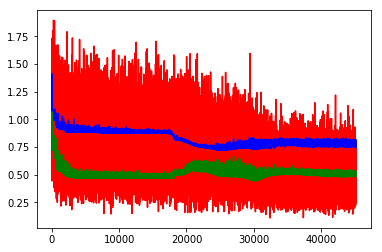

In [37]:
plt.plot(err_epoh, color='r')
plt.plot(valid_err_epoh, color='b')
plt.plot(test_err_epoh, color='g')

plt.savefig(HOME_DIR+'GD/train_valid_test.png', bbox_inches='tight')

In [38]:
print("train:")
print(max(err_epoh))
print(math.sqrt(np.var(err_epoh)))
print(math.sqrt(np.mean(err_epoh)))

print("valid:")
print(max(valid_err_epoh))
print(math.sqrt(np.var(valid_err_epoh)))
print(math.sqrt(np.mean(valid_err_epoh)))

print("test:")
print(max(test_err_epoh))
print(math.sqrt(np.var(test_err_epoh)))
print(math.sqrt(np.mean(test_err_epoh)))

train:
[1.8947779]
0.2418063071018179
0.8117159948953936
valid:
[1.4108182]
0.06408207466382129
0.90598618844012
test:
[1.066448]
0.041045646239048626
0.7145454326250636


ГРАФИКИ ВЫХОДА ДО И ПОСЛЕ ОБУЧЕНИЯ:

In [27]:
net1 = MainNet()

net1.lin1.W = Parameter(torch.FloatTensor(pd.read_csv('w1.csv', header=None)[1].values[1:]).unsqueeze(1))
net1.lin2.W = Parameter(torch.FloatTensor(pd.read_csv('w2.csv', header=None)[1].values[1:]).unsqueeze(0))
net1.lin1.b = Parameter(torch.FloatTensor(pd.read_csv('b1.csv', header=None)[1].values[1:]))
net1.lin2.b = Parameter(torch.FloatTensor(pd.read_csv('b2.csv', header=None)[1].values[1:]))


In [28]:
net = MainNet()

net.lin1.W = Parameter(torch.FloatTensor(pd.read_csv('w1_before.csv', header=None)[1].values[1:]).unsqueeze(1))
net.lin2.W = Parameter(torch.FloatTensor(pd.read_csv('w2_before.csv', header=None)[1].values[1:]).unsqueeze(0))
net.lin1.b = Parameter(torch.FloatTensor(pd.read_csv('b1_before.csv', header=None)[1].values[1:]))
net.lin2.b = Parameter(torch.FloatTensor(pd.read_csv('b2_before.csv', header=None)[1].values[1:]))

0.12229587591754623 0.9001757016604073


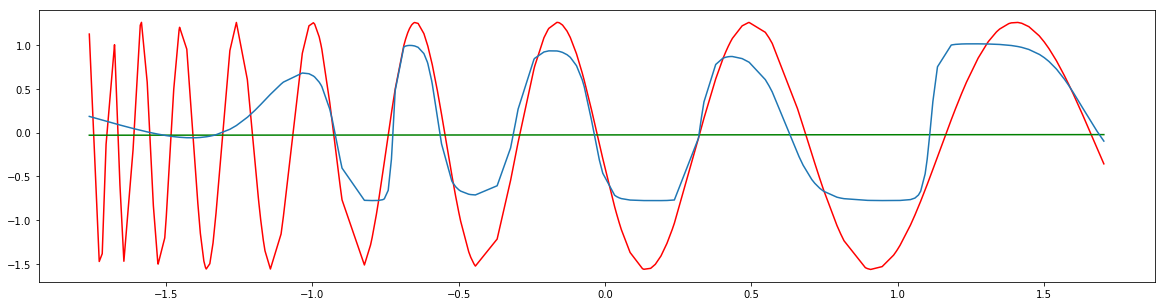

In [35]:
df_buf = pd.DataFrame(dataset.data)
df_buf = df_buf.sort_values(by=0)

x = autograd.Variable((torch.from_numpy(df_buf.get_values()[:, 0]).float()).unsqueeze(1))

y_pred = net.forward(x)
y = net1.forward(x)
x = x.data.numpy()
y_pred = y_pred.data.numpy()
y = y.data.numpy()
y = y*STD_Y+MEAN_Y
print(MEAN_Y, STD_Y)
plt.figure(figsize=(20, 5))
plt.plot(df_buf[0], df_buf[1], color='r')
plt.plot(x, y_pred, 'g')
plt.plot(x, y)
plt.savefig('before_after_training1.png', bbox_inches='tight')

ВЕСА СКРЫТОГО И ВЫХОДНОГО СЛОЕВ И ВЫХОДЫ НЕЙРОНОВ СКРЫТОГО СЛОЯ (ВСЁ ПО ПОРЯДКУ):

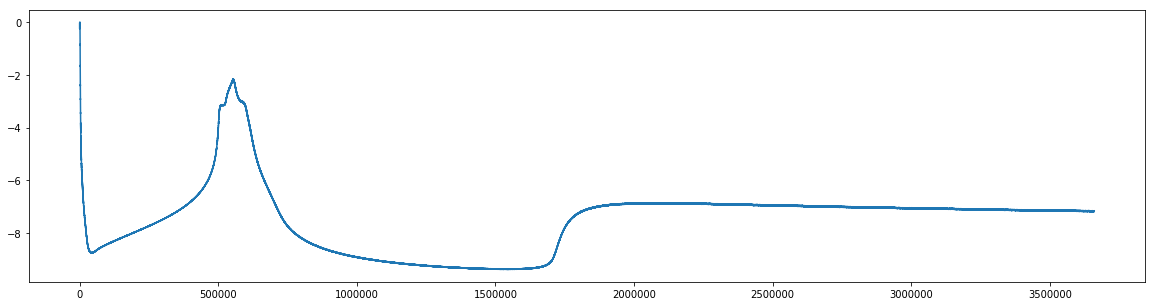

In [38]:
w2hid = []
for i in range(len(weight2_hidden)):
    w2hid.append(weight2_hidden[i][0])

weight2_hidden = w2hid

plt.figure(figsize=(20, 5))
plt.plot(w2hid)
plt.savefig('w2_hidden.png', bbox_inches='tight')

In [40]:
w2hid = []
for i in range(len(wieght2_out)):
    w2hid.append(wieght2_out[i][0])

wieght2_out = w2hid

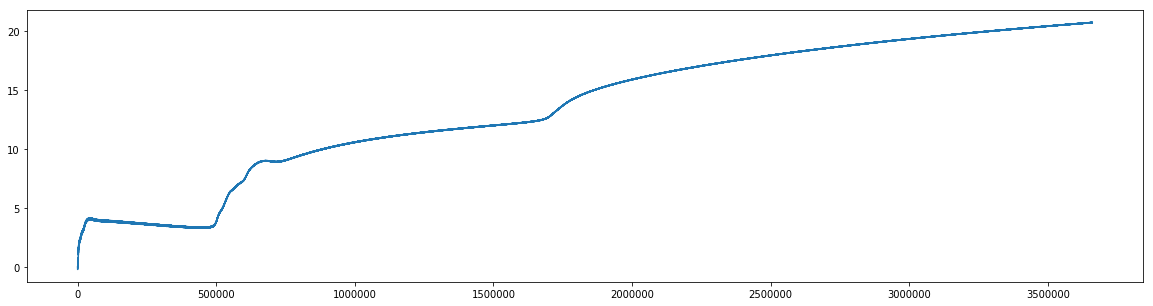

In [42]:

plt.figure(figsize=(20, 5))
plt.plot(wieght2_out)
plt.savefig('w2_out.png', bbox_inches='tight')

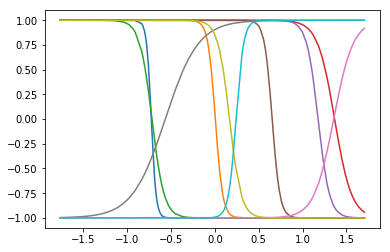

In [43]:
net1.lin1.W = net.lin1.W
net1.lin1.b = net.lin1.b

x = autograd.Variable((torch.from_numpy(x).unsqueeze(1)))
y_pred = net1.forward(x)
x = x.data.squeeze().numpy().reshape((240, 1))
for i in range(y_pred.size()[2]):
    buf = y_pred[:, :,  i].data.numpy()
    plt.plot(x, buf)
plt.savefig('after_training_yk.png', bbox_inches='tight')

СОХРАНЯЛКА:

In [26]:
w1 = pd.DataFrame((net.lin1.W).data.numpy())
b1 = pd.DataFrame((net.lin1.b).data.numpy())
w2 = pd.DataFrame((net.lin2.W).data.numpy().T)
b2 = pd.DataFrame((net.lin2.b).data.numpy())
print(w2)

w1.to_csv('w1.csv')
w2.to_csv('w2.csv')
b1.to_csv('b1.csv')
b2.to_csv('b2.csv')

            0
0   -0.208409
1    0.009525
2    2.457850
3    0.109509
4   -0.182267
5    2.328668
6    9.376623
7   -0.150368
8   -0.101178
9    2.289853
10   3.670721
11  -0.147978
12  -0.186362
13  -0.255317
14   4.501236
15  -0.027208
16   0.175701
17   0.233758
18  -0.336675
19  -0.163541
20  -0.183322
21   2.344121
22  -5.820778
23  12.220947
24   3.539526
25  -0.398664
26   0.413931
27  -0.098314
28   2.078848
29  -0.188985


In [47]:
w1 = Parameter(torch.from_numpy(pd.read_csv('w1.csv', header=None)[1].values[1:]))
w2 = Parameter(torch.from_numpy(pd.read_csv('w2.csv', header=None)[1].values[1:].T))
b1 = Parameter(torch.from_numpy(pd.read_csv('b1.csv', header=None)[1].values[1:]))
b2 = Parameter(torch.from_numpy(pd.read_csv('b2.csv', header=None)[1].values[1:]))


net.lin1.W = Parameter(torch.FloatTensor(pd.read_csv('w1.csv', header=None)[1].values[1:]).unsqueeze(1))
net.lin2.W = Parameter(torch.FloatTensor(pd.read_csv('w2.csv', header=None)[1].values[1:]).unsqueeze(0))
net.lin1.b = Parameter(torch.FloatTensor(pd.read_csv('b1.csv', header=None)[1].values[1:]))
net.lin2.b = Parameter(torch.FloatTensor(pd.read_csv('b2.csv', header=None)[1].values[1:]))

# 